# PyTorch Implementation: Deep Painterly Harmonization
---
Seonkyu Park

## Contents

1. Introduction
1. Preparation
  - Model
  - Input Images
2. First Pass
  - Independent Mapping
  - Reconstruction
3. Second Pass
  - Consistent Mapping
  - Reconstruction
4. Post Processing
  - Chrominance Denoising
    

## Introduction

This is an implementation of [Deep Painterly Harmonization](https://arxiv.org/abs/1804.03189) paper with PyTorch. List of modules needed is as following.

**todo: add picture**

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import vgg16_bn, vgg19_bn
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize, Resize
from tqdm import tqdm
from PIL import Image

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Preparing CNN model

Define the CNN model which will be used as feature extracter. Running the following line will download pretrained model file (550 MB) to your local machine.

In [2]:
class FeatureExtracter(nn.Module):
    def __init__(self):
        super(FeatureExtracter, self).__init__()
        model = vgg16_bn(pretrained=True).features
        indices = [0, 3, 10, 17, 27, 37]
        self.layers = self._slice_layers(model, indices) 
    
    def forward(self, x):
        out = []
        for l in self.layers:
            x = l(x)
            out.append(x)
        return out

    def _slice_layers(self, model, indices):
        layers = []
        for i in range(len(indices) - 1):
            layer = nn.Sequential(*list(model.children())[indices[i]:indices[i + 1]])
            layers.append(layer)
        return nn.Sequential(*layers)

In [3]:
model = FeatureExtracter()
for p in model.parameters():
    p.requires_grad = False
print(model)

FeatureExtracter(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace)
    )
    (2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(

This model class will compute and return the wanted intermidiate feature maps of input image as a python list of tensors using pretrained VGG network.

## Preparing Inputs
The inputs of deep harmonization algorithm are following. Shape of all images are same except that the mask has 1 channel, while the others have 3(R, G, B) channels.

**Style Image** is the background image that the object will be pasted.

**Content Image** is the image containing object that will be moved. 

**Mask** is a binary mask indicating the parts of image that contains moved object. The masks are set slightly larger than objects.

**Target Image** is the tensor to be optimized. It is set to be a copy of input image in the first pass, and to be result of first pass in the second pass

In [4]:
# define pathes
data_path = 'data/'

index = 9
img_style = Image.open(os.path.join(data_path, f'{index}_target.jpg'))
img_content = Image.open(os.path.join(data_path, f'{index}_naive.jpg'))
img_mask = Image.open(os.path.join(data_path, f'{index}_c_mask_dilated.jpg'))

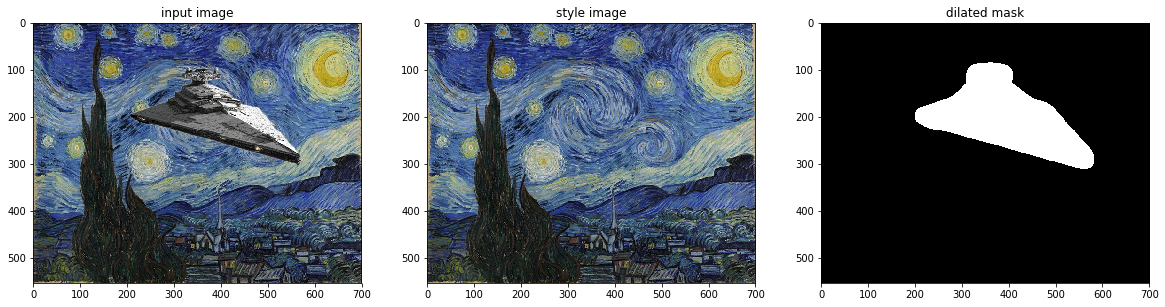

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('input image')
plt.imshow(img_content)
plt.subplot(132)
plt.title('style image')
plt.imshow(img_style)
plt.subplot(133)
plt.title('dilated mask')
plt.imshow(img_mask)

In [6]:
# transforms used by all pretrained models in pytorch, ref: https://pytorch.org/docs/stable/torchvision/models.html
normalize     = Normalize(mean=[0.485, 0.456, 0.406], 
                          std= [0.229, 0.224, 0.225])
inv_normalize = Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],    
                          std=[1/0.229, 1/0.224, 1/0.255])

to_tensor = Compose([
    ToTensor(),
    normalize])
to_image = Compose([
    inv_normalize,
    ToPILImage()])

#### TODO: move tensors, model to device

In [1]:
tensor_mask = ToTensor()(img_mask)[0].byte() # drop G, B channels

NameError: name 'ToTensor' is not defined

In [8]:
dummy_input = torch.rand(2, 3, 554, 700)

In [9]:
tensor_style = to_tensor(img_style).unsqueeze_(0)
tensor_content = to_tensor(img_content).unsqueeze_(0)
batch_inputs = torch.cat([tensor_style, tensor_content], dim=0) # concat style and content images

# copy content image and set the trainable flag True
tensor_target = tensor_content
tensor_target.requires_grad = True

Feed input batch to the model to gain the reference activations. This batch_ref is python list containing intermidiate feature batches of both style(index 0) and content(index 1) image. The content features will be used as is, but style features will go through some modifications(nearest neighbor matching).

In [ ]:
batch_ref = model(batch_inputs)

Resize mask to the sizes of reference layers

In [13]:
def resize_masks(mask, reference_output):
    result = []
    for l in reference_output:
        resize = Resize(l.shape[-2:])
        result.append(ToTensor(resize(mask)))
    return result

In [14]:
masks = resize_masks(img_mask, ref_content)

NameError: name 'ref_content' is not defined

## vector representation of features

in this article, activation blocks are considered as a collection of vectors, rather than of channels. Following function selects activation vectors inside of given mask, and return flattened matrix whose columns are activation vector. If mask is None(Not given), this function just flatten the activation volume into a matrix with shape (channel, width \* height)

#### TODO: add figure

In [26]:
def select_mask(features, mask=None):
    """
    select activation vectors in mask
    features: (c, w, h)
    mask: (w, h)
    """
    c, w, h = features.shape
    if mask is not None:
        activations = torch.masked_select(features[i], mask).view(c, -1)
    else:
        activations = features.view(c, -1)
    
    return torch.cat(activations, dim=0)

## Mapping

Before calculating the loss, 

In [27]:
def get_patches(features, mask=None):
    grid = [(-1, -1), (-1, 0), (-1, 1),
            ( 0, -1), ( 0, 0), ( 0, 1),
            ( 1, -1), ( 1, 0), ( 1, 1)]
    c, w, h = features.shape
    if mask is None:
        mask = torch.ones((w, h), dtype=torch.uint8)
    assert(mask.shape == (w, h))
    features_padded = F.pad(features, (1, 1, 1, 1), mode='reflection') # TODO: try reflection padding
    mask_padded = F.pad(mask, (2, 2, 2, 2))
    selected = []
    for offset in grid:
        dx, dy = offset
        x0, y0 = 1, 1
        x1, y1 = w+3, h+3
        
        offset_mask = mask_padded[x0+dx : x1+dx , y0+dy : y1+dy]
        selected.append(select_mask(features_padded, offset_mask))
    patches = torch.cat(selected)
    return patches

In [28]:
def nearest_mapping(f_input, f_style, mask):
    patch_input = get_patches(f_input, mask)
    patch_style = get_patches(f_style)
    
    # compute matrix of l2 norm between each pairs of patches
    l2_input = torch.sum(patch_input**2, dim=0).t()
    l2_style = torch.sum(patch_style**2, dim=0)
    
    prod = torch.mm(patch_input.t(), patch_style)
    l2_matrix = l2_input + l2_style - 2 * prod # sqrt is omitted since it will have no effect on comparing
    _, nearest_idx = torch.argmax(l2_matrix, dim=1)
    
    # remap the activation vectors of style features using nearest indices
    mapped_features = torch.cat([row.take(nearest_idx).unsqueeze(0) for row in select_mask(f_style)], dim=0)
    mapped_style = f_style.masked_scatter(mask, mapped_features)
    
    return mapped_style

## Loss Functions in Style Transfer 

In [29]:
def gram(inp):
    return torch.mm(inp, inp.transpose(0, 1))

def loss_content(output, target, mask):
    return F.mse_loss(
        select_mask(output, mask), 
        select_mask(target, mask))

def loss_style(output, target, mask):
    return F.mse_loss(
        gram(select_mask(output, mask)), 
        gram(select_mask(target, mask)))

## First Pass

In [33]:
max_iter = 1000
show_iter = 100

indices_content = [3]
indices_style = [2, 3, 4]

optimizer = optim.LBFGS([tensor_target], lr=1)


NameError: name 'opt_img_v' is not defined

In [ ]:
def step_pass1():
    optimizer.zero_grad()
    
    loss = loss_fn(opt_img_v)
    loss.backward()
#     n_iter += 1
#     if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [ ]:
loss_total = torch.tensor([0.0])
for layer_idx, layer in enumerate(f_batch):
    features_input = layer[0]
    features_style = layer[1]
    
    loss_content = torch.tensor([0.0])
    loss_style = torch.tensor([0.0])
    
    if layer_idx in indices_content:
        loss_c += loss_content()
        loss_s += loss_style()

In [ ]:
# code reference: https://github.com/sgugger/Deep-Learning/blob/master/DeepPainterlyHarmonization.ipynb
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter += 1
    if n_iter % show_iter == 0:
        print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [ ]:
n_iter = 0
while n_iter <= max_iter:
    optimizer.step(partial(step, stage1_loss))

## Second Pass

In [ ]:
def second_pass_harmonization():
    pass

In [ ]:
index = 9
img_style = Image.open(os.path.join(data_path, f'{index}_target.jpg'))
img_content = Image.open(os.path.join(data_path, f'{index}_naive.jpg'))
img_intermediate = np.load(f'{index}_out1.jpg')
img_mask = Image.open(os.path.join(data_path, f'{index}_c_mask_dilated.jpg'))

## Histogram Matching

### References
[Deep Painterly Harmonization Paper](https://arxiv.org/abs/1804.03189)

[Author's code](https://github.com/luanfujun/deep-painterly-harmonization)

[Sylvain Gugger's Blog](https://sgugger.github.io/deep-painterly-harmonization.html)